In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
ticker = 'AAPL'
data = yf.download(ticker, start = "2020-01-01", end="2025-12-01")
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468246,72.528566,71.223244,71.476585,135480400
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800
2020-01-06,72.335541,72.374146,70.634524,70.885457,118387200
2020-01-07,71.995346,72.600952,71.775781,72.345197,108872000
2020-01-08,73.153503,73.455103,71.698589,71.698589,132079200
...,...,...,...,...,...
2025-11-21,271.489990,273.329987,265.670013,265.950012,59030800
2025-11-24,275.920013,277.000000,270.899994,270.899994,65585800


Train Range 2020-03-13 00:00:00 2024-10-04 00:00:00
Test Range 2024-10-04 00:00:00 2025-11-26 00:00:00
Fitting RandomForest (may take a while)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 3}

Fitting XGBoost (may take a while)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'model__subsample': 0.6, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}
Running walk-forward backtest for RF...
Running walk-forward backtest for XGB...
Walk-forward RF metrics:
{'cum_return': np.float64(0.3309286433429106), 'ann_return': np.float64(0.13347560677868553), 'annual_volume': np.float64(0.2714247863386388), 'sharpe': np.float64(0.49175909311449845), 'maxdd': np.float64(-0.27714736811508395)}
Walk-forward XGB metrics:
{'cum_return': np.float64(0.694095134768556),

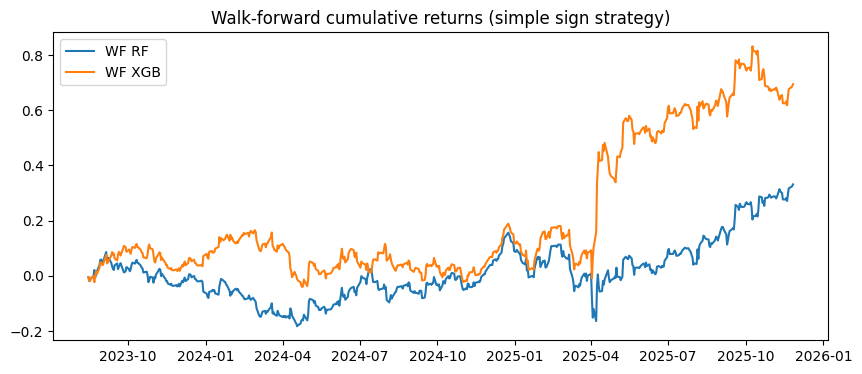

In [3]:
df = data.copy()
df['return'] = df['Close'].pct_change().shift(-1)
#momentum:
df['mom_5'] = df['Close'] - df['Close'].shift(5) #👉 “How much did today’s price change compared to 5 days ago?”
df['mom_10'] = df['Close'] - df['Close'].shift(10)

# Moving averages & cross features:
df['ma_5'] = df['Close'].rolling(5).mean() 
df['ma_10'] = df['Close'].rolling(10).mean()
df['ma_20'] = df['Close'].rolling(20).mean()
df['ma_50'] = df['Close'].rolling(50).mean()
df['ma_5_20_diff'] = df['ma_5'] - df['ma_20']

#Volatility:
df['pct_change'] = df['Close'].pct_change()
df['vol_20'] = df['pct_change'].rolling(20).std()
df['vol_5'] = df['pct_change'].rolling(5).std()

# RSI (Wilder smoothing)
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
window = 14
avg_gain = gain.ewm(alpha = 1/window, adjust = False).mean()
avg_loss = loss.ewm(alpha=1/window, adjust = False).mean()
rs = avg_gain/avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

#volume_feature:
df['volume_bur'] = df['Volume'] / df['Volume'].rolling(20).mean()


# Price returns & lagged returns
df['return_1'] = df['Close'].pct_change()
df['return_2'] = df['Close'].pct_change(2)

# Add lags
for lag in [1,2,3]:
    df[f'mom_5_lag{lag}'] = df['mom_5'].shift(lag)

# Drop intermediate
df.drop(columns = ['pct_change'], inplace = True)
df = df.dropna().copy()

if len(df) < 100:
    raise ValueError(f"Not enough data after dropna(): {len(df)} rows")


#features and target:
features = [ 'mom_5','mom_10','ma_5','ma_10','ma_20','ma_50','ma_5_20_diff',
    'vol_20','vol_5','rsi_14','volume_bur','return_1','return_2',
    'mom_5_lag1','mom_5_lag2','mom_5_lag3']
X = df[features]
y = df['return']
df
#to confirm no NaN:
assert X.isna().sum().sum() == 0
assert y.isna().sum() == 0

# ========== 4) Time-based train/test split ==========
# Use a time-based split (do NOT shuffle)
split_Date = df.index[int(len(df)*0.80)]
X_train = X.loc[:split_Date] #2024-01-01 → 2024-01-09  (9 rows)
X_test = X.loc[split_Date:] #2024-01-09 → 2024-01-10  (2 rows)
y_train = y.loc[:split_Date] #2024-01-01 → 2024-01-09  (9 rows)
y_test = y.loc[split_Date:] #2024-01-09 → 2024-01-10  (2 rows)
print('Train Range', X_train.index.min(), X_train.index.max())
print('Test Range', X_test.index.min(), X_test.index.max())

# ========== 5) Pipeline: impute -> scale -> model ==========
pipe_rf = Pipeline([
   ( 'imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators = 200, random_state = 0, n_jobs = -1))
])

pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(n_estimators = 300, tree_method = 'hist', verbosity = 0))
])

# ========== 6) TimeSeries CV and Randomized Search for hyperparams ==========
tscv = TimeSeriesSplit(n_splits = 5)


# RandomForest search space
rf_param_dist = {
      'model__n_estimators': [200, 300, 500],
    'model__max_depth': [3, 5, 8, 12, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4] #takes 1 data return = 5%, takes 2 data return average it 4.5% etc.
}

# XGBoost search space
XGB_param_dist = {
     'model__n_estimators': [200, 300, 500],
    'model__max_depth': [3, 5, 8, 12],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

rf_search = RandomizedSearchCV(
   param_distributions = rf_param_dist,
   estimator = pipe_rf,
    cv = tscv,
    n_iter = 20,
    scoring = 'neg_mean_squared_error',
    random_state = 0,
    n_jobs = -1,
    verbose = 1
)

xgb_search = RandomizedSearchCV (
    pipe_xgb,
    XGB_param_dist,
    cv = tscv,
    n_iter = 20,
    scoring = 'neg_mean_squared_error',
    random_state = 0,
    n_jobs = -1,
    verbose = 1
)

print("Fitting RandomForest (may take a while)...")
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_
print("\nFitting XGBoost (may take a while)...")
xgb_search.fit(X_train,y_train)
print("Best RF params:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_


# ========== 8) Evaluate on test set ==========

def evaluate_regression (y_true, y_pred, prefix = 'Model'):
    r2 = r_score(y_true,y_predict),
    mse = mean_squared_error(y_true,y_pred),
    rmse = np.sqrt(mse)
    mae = mean_absolute_square(y_true,y_pred)
    pnl = y_true * y_pred,
    ret = pnl.mean(),
    vol = pnl.std()
    sharpe = (ret/vol)*np.sqrt(252) if vol !=0 else np.nan
    print(f"{prefix}  R2: {r2:.6f}, RMSE: {rmse:.6e}, MAE: {mae:.6e}, Sharpe(est): {sharpe:.4f}")
    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'sharpe': sharpe}

    y_pred_rf = best_rf.predict(X_test)
    y_pred_xgb = best_xgb.predict(X_test)

    print("RF evaluation:")
    rf_metrics = evaluate_regression(y_test.values, y_pred_rf, prefix = 'RandomForest')
    print("XGB evaluation:")
    xgb_metrics = evaluate_regression(y_test.values, y_pred_xgb, prefix = 'XGBoost')

    # ========== 9) Walk-forward backtest (rolling predictions) ==========
def walk_forward_backtest (X, y, model_pipeline, train_window = 0.6, step = 63):
        n = len(X)
        if isinstance (train_window, float):
            start_train = int(n*train_window)
        else:
            start_train = int(train_window)

        i = start_train
        preds = []
        trues = []
        dates = []

        while i < n:
            X_train_w = X.iloc[:i]
            y_train_w = y.iloc[:i]
            X_test_w = X.iloc[i:i+step]
            y_test_w = y.iloc[i:i+step]
            if len(X_train_w) == 0:
                break
            model_pipeline.fit(X_train_w, y_train_w)
            p = model_pipeline.predict(X_test_w)
            preds.extend(p) #What model predicted
            trues.extend(y_test_w.values) #What actually happened
            dates.extend(X_test_w.index) #On which date
            i += step
        return pd.DataFrame({'y_true': np.array(trues), 'y_pred': np.array(preds)}, index=pd.DatetimeIndex(dates))
print("Running walk-forward backtest for RF...")
wf_rf = walk_forward_backtest(X, y, best_rf, train_window = 0.6, step = 63)
print("Running walk-forward backtest for XGB...")
wf_xgb = walk_forward_backtest(X, y, best_xgb, train_window = 0.6, step = 63)
         
def backtest_metrics (wf_df):
        pos = np.sign(wf_df['y_pred'])
        pnl = pos * wf_df['y_true']
        cumret = (1 + pnl).cumprod()-1
        daily_ret = pnl
        ann_return = (1 + cumret.iloc[-1]) ** (252/len(cumret)) - 1 if len(cumret) > 0 else np.nan
        annual_volume = daily_ret.std() * np.sqrt(252)
        sharpe = ann_return / annual_volume if annual_volume != 0 else np.nan
        #max_drawdown:
        cum = (1 + daily_ret).cumprod()
        highwater = cum.cummax()
        drawdown = (cum - highwater) / highwater
        maxdd = drawdown.min()
        return {'cum_return': cumret.iloc[-1], 'ann_return': ann_return, 'annual_volume': annual_volume, 'sharpe': sharpe, 'maxdd': maxdd}

print("Walk-forward RF metrics:")
print(backtest_metrics(wf_rf))
print("Walk-forward XGB metrics:")
print(backtest_metrics(wf_xgb))

# ========== 10) Feature importance ==========
# For RandomForest (from the fitted estimator inside pipeline)
feature_cols = X.columns

rf_feat_importances = best_rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(rf_feat_importances, index=feature_cols).sort_values(ascending=False)
print("Top features (RF):\n", feat_imp.head(10))

# For XGBoost
xgb_feat_importances = best_xgb.named_steps['model'].feature_importances_
feat_imp_xgb = pd.Series(xgb_feat_importances, index=feature_cols).sort_values(ascending=False)
print("Top features (XGB):\n", feat_imp_xgb.head(10))

# Optional: SHAP for deeper explainability (recommended for interviews)
# import shap
# explainer = shap.Explainer(best_xgb.named_steps['model'])
# shap_values = explainer(best_xgb.named_steps['scaler'].transform(X_train))
# shap.summary_plot(shap_values, features=X_train, feature_names=feature_cols)

# ========== 11) Save best model ==========
# Choose whichever performed best on your holdout / walk-forward test
final_model = best_xgb  # or best_rf
joblib.dump(final_model, "final_trading_model.joblib")
print("Saved final model to final_trading_model.joblib")

# ========== 12) Quick plots ==========
plt.figure(figsize=(10,4))
plt.plot((1 + (np.sign(wf_rf['y_pred']) * wf_rf['y_true'])).cumprod() - 1, label='WF RF')
plt.plot((1 + (np.sign(wf_xgb['y_pred']) * wf_xgb['y_true'])).cumprod() - 1, label='WF XGB')
plt.title('Walk-forward cumulative returns (simple sign strategy)')
plt.legend()
plt.show()

In [7]:
latest_features = X.iloc[[-1]]
latest_date = latest_features.index[0]

# Predict return
predicted_return = best_xgb.predict(latest_features)[0]

# Get today's price as a FLOAT
today_price = df.loc[latest_date, 'Close'].item()

# Predict tomorrow price
tomorrow_price = today_price * (1 + predicted_return)

print(f"Date: {latest_date}")
print(f"Today's Close: {today_price:.2f}")
print(f"Predicted Return: {predicted_return*100:.2f}%")
print(f"Predicted Tomorrow Price: {tomorrow_price:.2f}")

Date: 2025-11-26 00:00:00
Today's Close: 277.55
Predicted Return: 0.04%
Predicted Tomorrow Price: 277.67
